<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v4: Weight visualisation during learning
This is a new attempt at visualising weight changes during learning, now that I have a better understanding of TensorFlow's auto-graph.

Focus of this notebook:
* generating heatmap images of gradients over time of learning.

Sample training domains:

---


* Deep Learning Specialization C2W2A1 experiments with weight initialisation, against a simple 2D binary classification problem.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

## Useful tools

In [2]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=None, display_total=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval
        self.display_total = display_total

    def set_params(self, params):
        self.epoch_count = params['epochs']
        if self.display_interval == None:
          self.display_interval = math.floor(self.epoch_count / self.display_total)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.display_interval == 0) or epoch == self.epoch_count-1:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

## Baseline: Simple model without visualisations
Actually, we're going to create a setup with few slightly different training regimes corresponding to the experiments from the coursework.


In [3]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


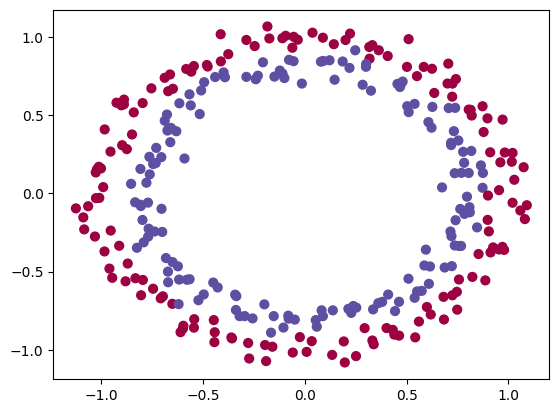

In [4]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [5]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch  1500: loss: 0.1388  
Epoch  3000: loss: 0.0358  
Epoch  4500: loss: 0.0165  
Epoch  6000: loss: 0.0106  
Epoch  7500: loss: 0.0080  
Epoch  9000: loss: 0.0069  
Epoch 10500: loss: 0.0064  
Epoch 12000: loss: 0.0062  
Epoch 13500: loss: 0.0061  
Epoch 15000: loss: 0.0061  
Total training time: 99.75 secs


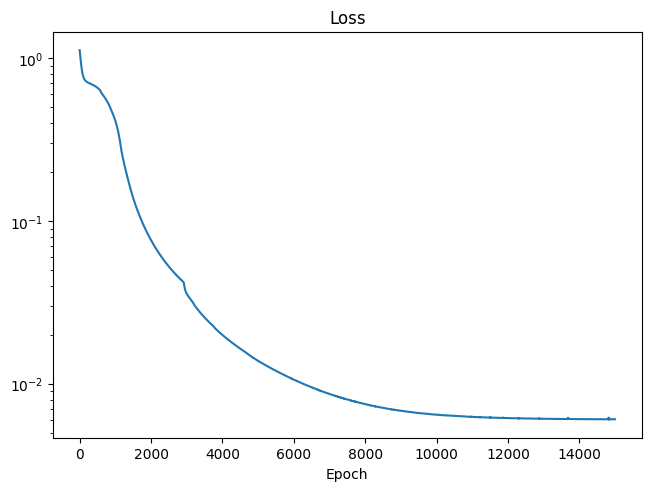

In [6]:
plot_fit(history)

## Quick Win: Weight Histogram
Let's create quick'n'dirty function for visualising the current weights, in the form of a histogram.

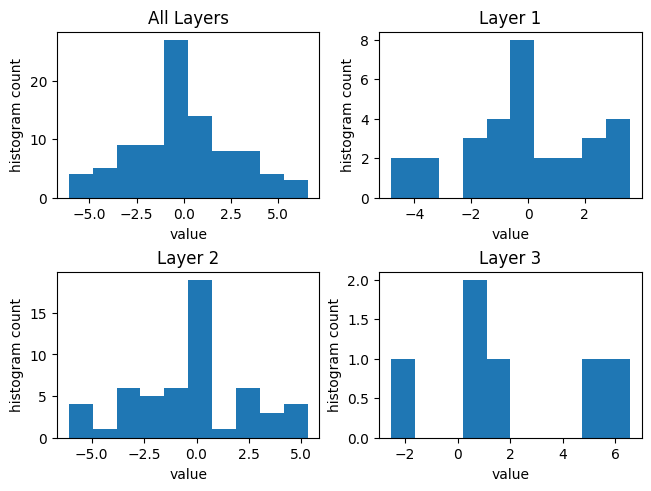

In [7]:
def plot_weights(model):
  """
  model - the model
  """

  # collect all variables across the entire model into a single flattened array
  all_variables = []
  for layer in model.layers:
    for weight in layer.weights:
      all_variables = np.append(all_variables, weight.numpy().flatten())

  L = len(model.layers)
  plots_tot = L+1
  plots_cols = math.floor(math.sqrt(plots_tot))
  plots_rows = math.ceil(plots_tot / plots_cols)

  plt.figure(layout='constrained')

  plt.subplot(plots_rows, plots_cols, 1)
  plt.title("All Layers")
  plt.hist(all_variables)
  plt.xlabel("value")
  plt.ylabel("histogram count")

  for l in range(L):
    variables = []
    for weight in model.layers[l].weights:
      variables = np.append(variables, weight.numpy().flatten())
    plt.subplot(plots_rows, plots_cols, l+2)
    plt.title(f"Layer {l+1}")
    plt.hist(variables)
    plt.xlabel("value")
    plt.ylabel("histogram count")
  plt.show()
plot_weights(model)

## Gradient heatmap
There's two things to do here:
1. Collect gradient information during training
2. Plot it in various ways.

TensorFlow doesn't seem to provide very good means for capturing gradient information during training. It's standard Logger interface doesn't get passed that information. Instead, an Optimizer-wrapper seems the only solution.

Furthermore, while using a `tf.TensorArray` seems like a sensible option, it seems to be optimized for use _within_ a `@tf.function` and can't be initialised outside like a `tf.Variable`. So I've so found the only solution is to store everything as a matrix inside a `tf.Variable`, with rows containing a flattened copy of all the necessary information, and successive rows representing successive iterations. This particular implementation adds a bit of a delay to execution time. The problem is that it doesn't know the total number of iterations up front, so we'll get a lot of re-allocation cost. I suspect a better approach is to combine a Callback with the optimizer wrapper, because the Callback gets enough information to pre-allocate the memory.

In [8]:
# Note the basic delegation implementation of optimizer was provided by ChatGPT and seems to be working
class LoggingOptimizerWrapper(tf.keras.optimizers.Optimizer):
  def __init__(self, optimizer='adam', name="LoggingOptimizerWrapper", **kwargs):
    """
    Args:
      delegate: real optimizer to wrap. String (name of optimizer) or optimizer instance. See `tf.keras.optimizers`.
    """
    if isinstance(optimizer, str):
      optimizer = tf.keras.optimizers.get(optimizer)
    super(LoggingOptimizerWrapper, self).__init__(f"{name}:{optimizer.name}", **kwargs)
    self._delegate = optimizer

    # the shape=None thing here tells the Variable to accept changing shapes
    # but it has the sideeffect that self._gradients_by_step.shape always returns None while executing.
    self._gradients_by_step = tf.Variable(np.zeros((0,0)), shape=tf.TensorShape(None), dtype=tf.float32)
    self._initialised = tf.Variable(0)

  def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    """
      Args:
        grads_and_vars: List of `(gradient, variable)` pairs.
    """
    grads_and_vars = list(grads_and_vars)
    grads, _ = zip(*grads_and_vars)

    # concatenate all gradient tuples into a single vector
    flattened_grads = tf.zeros(shape=(1,0))
    for grad in grads:
      flattened_grads = tf.concat([flattened_grads, tf.reshape(grad, [1, -1])], axis=1)

    # append to list (or just set list on first iteration)
    tf.cond(self._initialised < 1,
            lambda: self._gradients_by_step.assign(flattened_grads),
            lambda: self._gradients_by_step.assign(tf.concat([self._gradients_by_step, flattened_grads], axis=0)))
    self._initialised.assign(1)

    # delegate for default behaviour
    return self._delegate.apply_gradients(grads_and_vars, name, experimental_aggregate_gradients)

  # delegate all other methods and properties

  def build(self, var_list):
    super().build(var_list)

  def _create_slots(self, var_list):
    self._delegate._create_slots(var_list)

  def _create_hypers(self):
    self._delegate._create_hypers()

  def _prepare_local(self, var_device, var_dtype, apply_state):
    return self._delegate._prepare_local(var_device, var_dtype, apply_state)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    return self._delegate._resource_apply_dense(grad, var, apply_state)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    return self._delegate._resource_apply_sparse(grad, var, indices, apply_state)

  def get_config(self):
    base_config = super(LoggingOptimizerWrapper, self).get_config()
    return {**base_config, "_delegate": tf.keras.optimizers.serialize(self._delegate)}

  @classmethod
  def from_config(cls, config, custom_objects=None):
    delegate_config = config.pop('_delegate')
    delegate = tf.keras.optimizers.deserialize(delegate_config, custom_objects=custom_objects)
    return cls(delegate, **config)

  def _serialize_hyperparameter(self, hyperparameter):
    return self._delegate._serialize_hyperparameter(hyperparameter)

  def get_updates(self, loss, params):
    return self._delegate.get_updates(loss, params)

  def get_weights(self):
    return self._delegate.get_weights()

  def set_weights(self, weights):
    self._delegate.set_weights(weights)

  def variables(self):
    return self._delegate.variables()

  def get_slot(self, var, name):
    return self._delegate.get_slot(var, name)

  def get_slot_names(self):
    return self._delegate.get_slot_names()

model = binary_classification_model('he_normal')
#model.compile(optimizer=LoggingOptimizerWrapper(tf.keras.optimizers.Adam()), loss='binary_crossentropy')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=4, batch_size=train_X.shape[0])
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")

Epoch 1/4
1/1 [==============================] - 1s 724ms/step - loss: 0.9392
Epoch 2/4
1/1 [==============================] - 0s 9ms/step - loss: 0.9354
Epoch 3/4
1/1 [==============================] - 0s 11ms/step - loss: 0.9317
Epoch 4/4
1/1 [==============================] - 0s 9ms/step - loss: 0.9281
gradient_history: (4, 91)


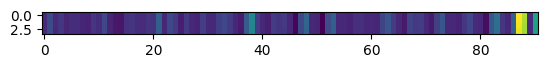

In [9]:
plt.imshow(gradient_history)

In [10]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=5000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch   500: loss: 0.4135  
Epoch  1000: loss: 0.1120  
Epoch  1500: loss: 0.0579  
Epoch  2000: loss: 0.0368  
Epoch  2500: loss: 0.0272  
Epoch  3000: loss: 0.0212  
Epoch  3500: loss: 0.0168  
Epoch  4000: loss: 0.0132  
Epoch  4500: loss: 0.0107  
Epoch  5000: loss: 0.0094  
gradient_history: (5000, 91)
Total training time: 28.83 secs


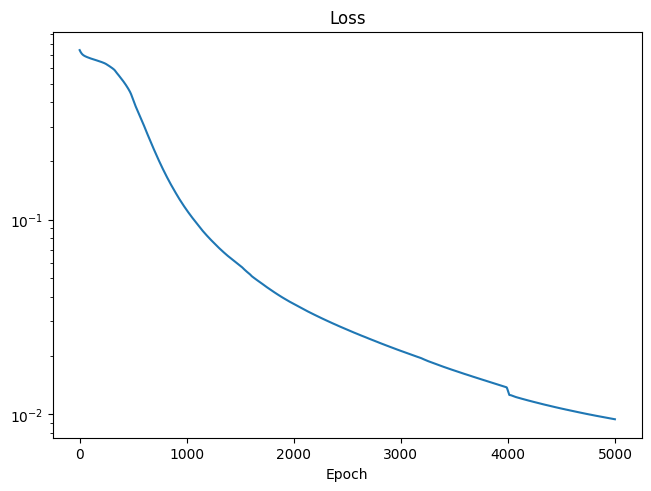

In [11]:
plot_fit(history)

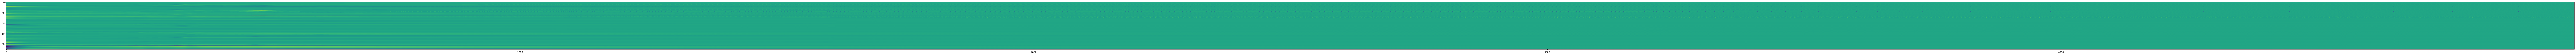

In [12]:
 plt.figure(figsize = (200,500))
plt.imshow(gradient_history.T)

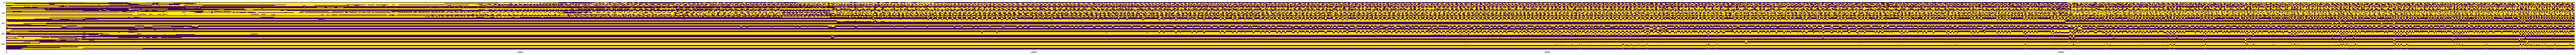

In [13]:
plt.figure(figsize = (200,500))
plt.imshow(np.sign(gradient_history.T))

In [14]:
gradient_history.shape

(5000, 91)

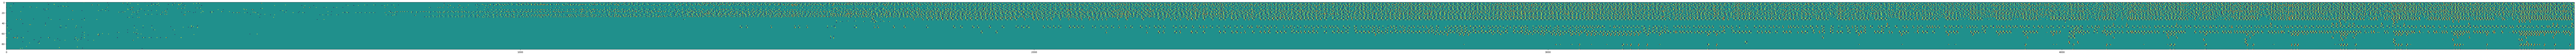

In [15]:
plt.figure(figsize = (200,500))
plt.imshow((np.sign(gradient_history[2:5000,:]) - np.sign(gradient_history[1:4999,:])).T)

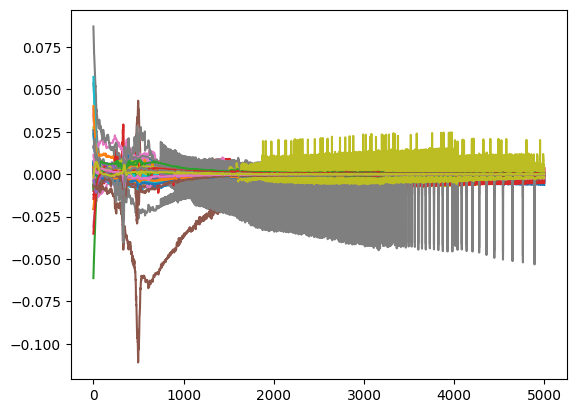

In [27]:
plt.plot(gradient_history[:,1:50])
plt.show()

## Filtering gradient information
Turning that data into something that clearly highlights when the gradient sign is fluctuating to an extent that causes a problem isn't going to be easy.
Let's start with a couple of interesting single variables and see what we can figure out.


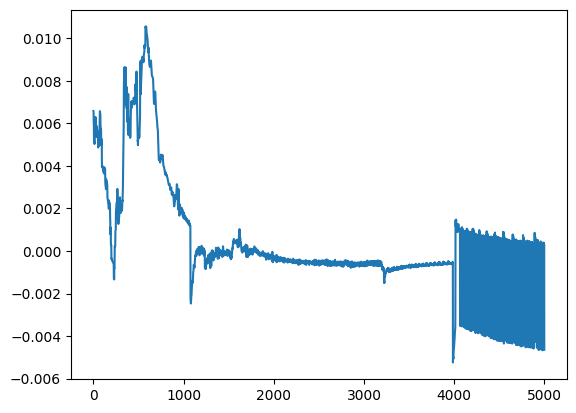

In [28]:
plt.plot(gradient_history[:,1])
plt.show()

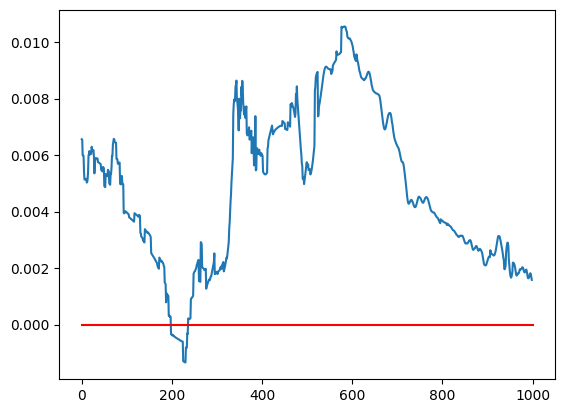

In [29]:
dat = gradient_history[1:1000,1]
plt.plot(dat)
plt.plot([0, 1000], [0, 0], 'r-')
plt.show()

Let's try to detect the peaks on each side of the zero-line. ie: the current "max" is reset when it changes sign.
And then we'll measure the current value relative to the current peak.

In [ ]:
def accumulate_peaks_with_zero_reset(dat):
  """
  dat: a 1D array of numbers
  """
  peak = 0
  out = []
  prev = 0
  for x in dat:
    if x == 0 or x * prev < 0:
      peak = x
    elif x > 0:
      peak = max(peak, x)
    else:
      peak = min(peak, x)
    out.append(peak)
    prev = x
  return np.array(out)

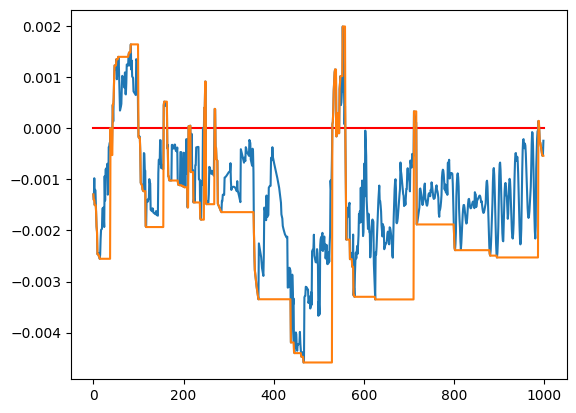

In [ ]:
peaks = accumulate_peaks_with_zero_reset(dat)
plt.plot([0, 1000], [0, 0], 'r-')
plt.plot(dat)
plt.plot(peaks)
plt.show()

In [ ]:
def accumulate_prev_peaks_with_zero_reset(dat):
  """
  dat: a 1D array of numbers
  """
  peaks = accumulate_peaks_with_zero_reset(dat)

  # Let:
  #  p0 = current peak of current block = p
  #  p1 = peak of prev block
  #  p2 = peak of prev prev block
  p1 = 0
  out = []
  prev = 0
  for p in peaks:
    if p == 0 or p * prev < 0:
      if prev != 0:
        p1 = prev
    out.append(p1)
    prev = p
  return np.array(out)


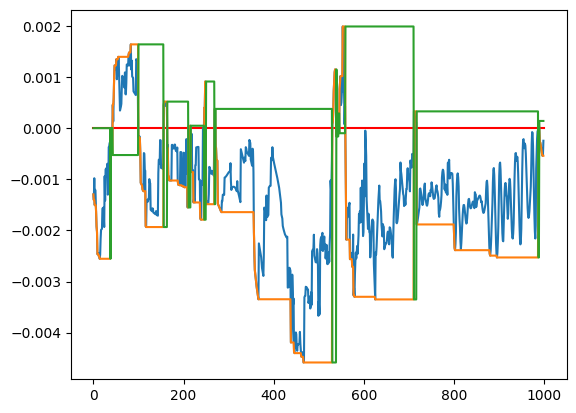

In [ ]:
peaks = accumulate_peaks_with_zero_reset(dat)
prev_peaks = accumulate_prev_peaks_with_zero_reset(dat)
plt.plot([0, 1000], [0, 0], 'r-')
plt.plot(dat)
plt.plot(peaks)
plt.plot(prev_peaks)
#plt.xlim(0,300)
plt.show()

Now work out the magnitude of difference between the current gradient and the previous block's peak.

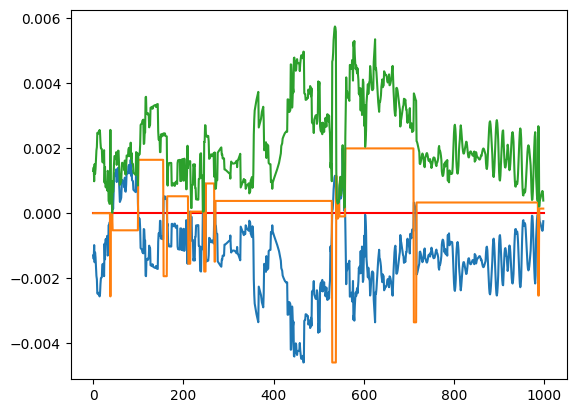

In [ ]:
prev_peaks = accumulate_prev_peaks_with_zero_reset(dat)
concern = abs(dat - prev_peaks)
#concern[np.sign(dat) == np.sign(prev_peaks)] = 0  ## this turns out to never trigger

plt.plot([0, 1000], [0, 0], 'r-')
plt.plot(dat)
plt.plot(prev_peaks)
plt.plot(concern)
plt.show()

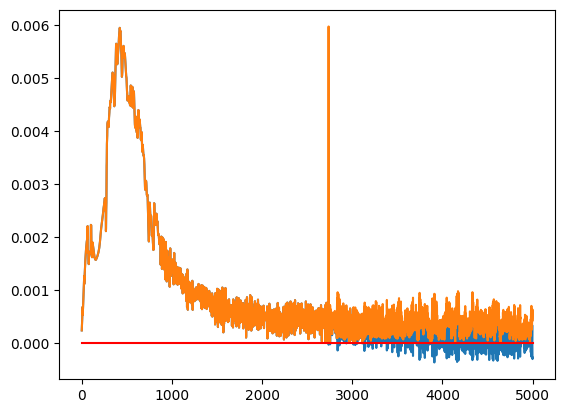

In [ ]:
dat2 = gradient_history[:,50]
prev_peaks = accumulate_prev_peaks_with_zero_reset(dat2)
concern = abs(dat2 - prev_peaks)

plt.plot(dat2)
plt.plot(concern)
plt.plot([0, 5000], [0, 0], 'r-')
plt.show()

Another thing is that I don't want to see squiggly lines throughout the entire sequence. I just want to know the place where the sign changes significantly, and its maximum amount. As a first simplistic approximation, I want to apply another filter that recognises where the new peak is reached, and shuts off any further output until a new event.

In [ ]:
def identify_eventpoints(dat):
  """
  dat: a 1D array of numbers
  """
  peaks = accumulate_peaks_with_zero_reset(dat)

  # traverse in reverse order starting from second to last entry
  out = []
  p0 = 0
  out.append(False)
  for i in reversed(range(len(dat)-1)):
    event = False
    if abs(peaks[i]) > 0 and np.sign(peaks[i]) != np.sign(peaks[i+1]):
      # new block
      event = True
      p0 = peaks[i]
    elif abs(peaks[i]) < abs(p0):
      event = True
    out.append(event)
  return np.flip(np.array(out))

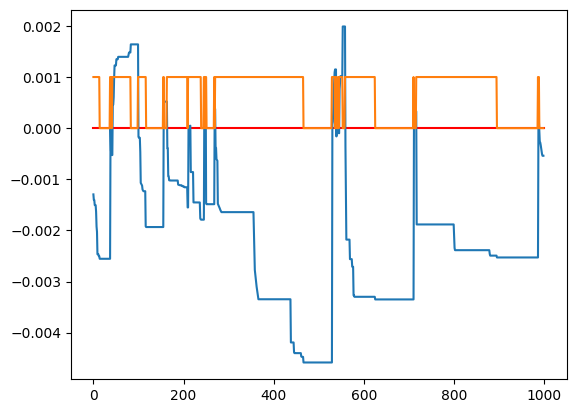

In [ ]:
peaks = accumulate_peaks_with_zero_reset(dat)
events = identify_eventpoints(dat)

plt.plot([0, 1000], [0, 0], 'r-')
#plt.plot(dat)
plt.plot(peaks)
plt.plot(events * 0.001)
plt.show()

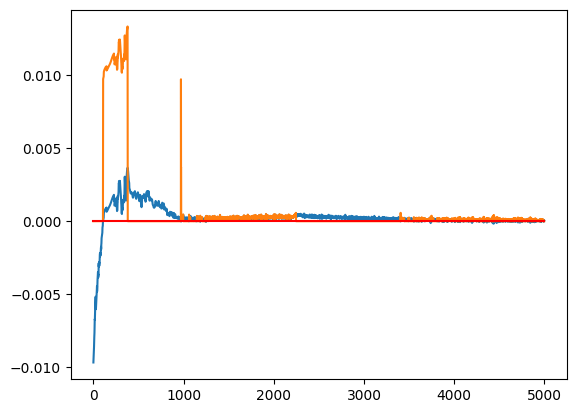

In [ ]:
dat2 = gradient_history[:,60]
prev_peaks = accumulate_prev_peaks_with_zero_reset(dat2)
events = identify_eventpoints(dat2)
concern = abs(dat2 - prev_peaks) * events

plt.plot(dat2)
plt.plot(concern)
plt.plot([0, 5000], [0, 0], 'r-')
plt.show()

In [64]:
math.log2(len(dat))

9.964340867792417

In [65]:
2**9

512

In [67]:
1 - 1/512

0.998046875

In [105]:
def accumulate_exp_averages(dat):
  """
  dat: a 1D array of numbers
  Returns:
    tensor
  """

  # Identify a range of betas that provide a power-of-2 sampling
  # of different equivalent window sizes, up to 1/5-th of the total length
  # of the data
  # rule: 1/(1-beta) ~= width of equivalent sliding window
  # =>    beta = 1 - 1/w
  max_window_base = math.floor(math.log2(len(dat)/5))
  window_size_bases = np.arange(1, max_window_base+1);
  window_sizes = 2**window_size_bases
  betas = 1 - 1/window_sizes
  print(f"window_sizes: {window_sizes}")
  print(f"betas: {betas}")

  out = []
  v = np.ones(len(betas)) * dat[0]
  for i, x in enumerate(dat):
    v = betas * v + (1 - betas) * x
    #v_unc = v
    #v = v / (1 - betas**(i+1) + 10e-8)
    #if i < 10:
    #  print(f"[{i}]: x: {x}, beta: {betas[3]}, betas**(i+1): {betas[3]**(i+1)}, v: {v_unc[3]} -> {v[3]}")
    out.append(v)

  return np.array(out)

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


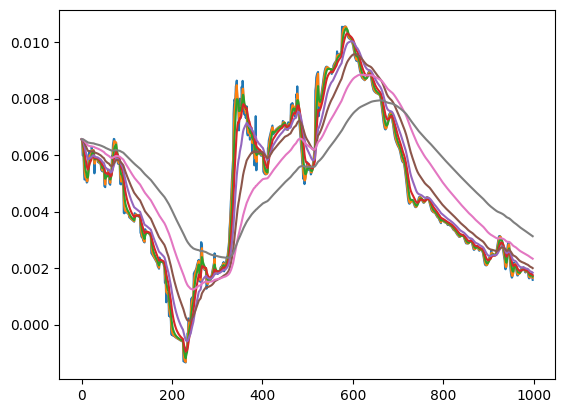

In [106]:
out = accumulate_exp_averages(dat)
plt.plot(dat)
plt.plot(out)
plt.show()

In [107]:
def identify_sign_changes(dat):
  smoothed = accumulate_exp_averages(dat)

  out = []
  prev = dat[0]
  for i, x in enumerate(dat):
    mag = 0.0
    if np.sign(x) != np.sign(prev):
      maxs = np.max(smoothed[i])
      mins = np.min(smoothed[i])
      if x == 0:
        mag = math.max(abs(maxs), abs(mins))
      elif x > 0:
        mag = maxs
      else:
        mag = mins
    out.append(mag)
    prev = x

  return np.array(out)

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]
window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


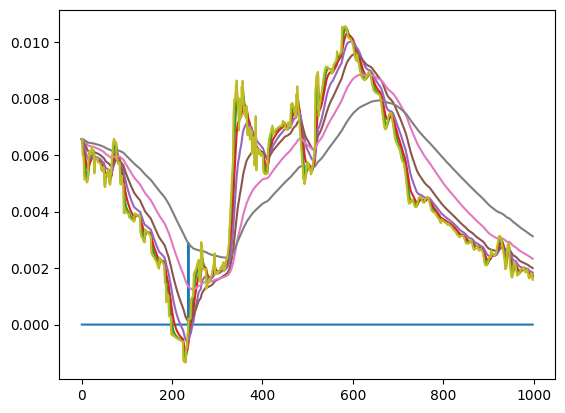

In [108]:
avgs = accumulate_exp_averages(dat)
events = identify_sign_changes(dat)
plt.plot(events)
plt.plot(avgs)
plt.plot(dat)
plt.show()

window_sizes: [  2   4   8  16  32  64 128 256 512]
betas: [0.5        0.75       0.875      0.9375     0.96875    0.984375
 0.9921875  0.99609375 0.99804688]
window_sizes: [  2   4   8  16  32  64 128 256 512]
betas: [0.5        0.75       0.875      0.9375     0.96875    0.984375
 0.9921875  0.99609375 0.99804688]


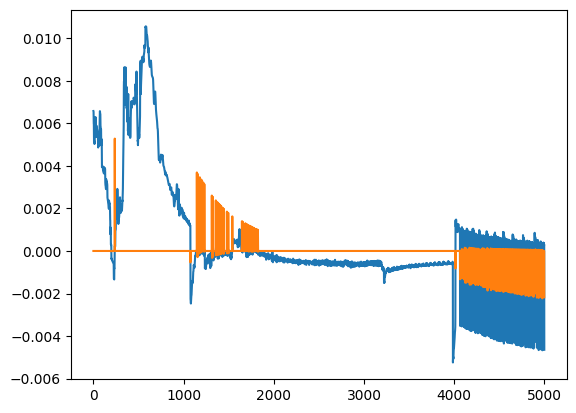

In [117]:
dat2 = gradient_history[:,1]
avgs = accumulate_exp_averages(dat2)
events = identify_sign_changes(dat2)
plt.plot(dat2)
#plt.plot(avgs)
plt.plot(events)
plt.show()